In [1]:
import requests
import pandas as pd
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from datetime import datetime
import random
import os
import warnings

import sys
sys.path.insert(0, 'scripts')
from scripts import card, map_classes, companion, calculate

from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

# The Commander Map

This notebook serves as the place for the final construction of the [Commander Map](https://luckypaper.co/resources/commander-map), using EDHREC decklists. Should you want to run this code yourself, you should reach out the EDHREC team for data access at `edhrec@edhrec.com`.

This notebook explains and runs the code to generate the June 2022 release of the [Commander Map](https://luckypaper.co/resources/commander-map). It may not reflect future versions. It also does not represent the full code used to generate the data used on the [LuckyPaper website](https://luckypaper.co)--there are a number of reformatting steps this notebook omits.

The data is composed of over 1.2 million (as of June 2022) Commander decklists collected from [archidekt.com](archidekt.com), [moxfield.com](moxfield.com), [mtggoldfish.com](mtggoldfish.com), [deckstats.net](deckstats.net), and [aetherhub.com](aetherhub.com). Our goal is to represent these decklists in two dimensions (as a "map"), as well as identify emergent patterns in the data. We will also generate "submaps", which depict all of the decks of a certain type (e.g. all Elf Tribal decks)

The code to generate the [main map](https://luckypaper.co/resources/commander-map) and submaps is approximately the same, so for now we'll focus on making the former. This code should accomplish the following:

1. Preprocess the data
    - This involves cleaning, filtering, and adding to the EDHREC data as well as reformatting the data in a way that lets us make the map.


2. Use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to generate the (x, y) position of each deck on the map.


3. Cluster the decks into decks of similar design.


4. Examine what defines these clusters.
    - This includes common commanders, tribes, themes, and color identities (__traits__) for each cluster, as well as common maindeck cards (__defining cards__).
    
Please note that running this code is __SLOW__. On my laptop, it takes over a day to run fully, and it may fail on computers without enough memory. There's a ton of data!


# Load and process the data

We begin by unzipping the EDHREC data into a folder, which we then rename after the data's release date. On my computer, this is under a `data` directory. So the path to the data is `data/{date}.`

In [11]:
date = '2022-06-24'

To clean the data, we need a reference dataset of Magic cards. [Scryfall](https://scryfall.com) is the go-to here.

## Load reference cards from Scryfall

We load data from Scryfall's `oracle-cards`, which encodes a single version for each card. Unfortunately, it's not quite good enough to use this out of the box—most deckbuilding sites represent double-sided cards using only their fronts. So sites will depict [Bonecrusher Giant](https://scryfall.com/card/eld/115/bonecrusher-giant-stomp), but Scryfall only stores [Bonecrusher Giant // Stomp](https://scryfall.com/card/eld/115/bonecrusher-giant-stomp) in this json. I've written a custom script that, when it encounters double sided cards in Scryfall's database, creates separate entries using both sides of the card.

In [5]:
# using the oracle cards significantly reduces the amount of data needed to load
resp = requests.get('https://api.scryfall.com/bulk-data/oracle-cards')
scryfall_download_uri = resp.json()['download_uri']

# implement the preprocessing
magic_cards = card.fetch_cards(scryfall_url = scryfall_download_uri, lower = False)

But the oracle cards do not accurately include pricing or the date of release of the card, as it contains data from only one version of each card. To accurately determine price and release date, we need to use all English versions, or `default-cards`. 

We use a function that scans all released versions of a card to identify the minimum price and earliest release of the card. For release dates, we use the spoiled date of the card, if available, or two weeks before its official release (reasoning that cards are often available on websites before the official release).

In [6]:
scryfall_resp = requests.get('https://api.scryfall.com/bulk-data/default-cards')
scryfall_download_uri = scryfall_resp.json()['download_uri']
resp = requests.get(scryfall_download_uri)
default_scryfall_cards = resp.json()

# add price and release date information
magic_cards = card.find_price_and_release(magic_cards, default_scryfall_cards)

# save memory
del default_scryfall_cards

For example, we can check [Hidetsugu, Devouring Chaos](https://scryfall.com/card/neo/99/hidetsugu-devouring-chaos), which was spoiled well before its release.

In [7]:
print('Released on', magic_cards['Hidetsugu, Devouring Chaos']['released_at'])
print('Available on', magic_cards['Hidetsugu, Devouring Chaos']['earliest_release'])

Released on 2022-02-18
Available on 2021-12-17


## Load EDHREC data

Now we load the EDHREC data. The formatting here is a bit wonky, but their README is reasonably straightforward:

```
This archive contains three CSV files: "decks.csv", "cards.csv", and "decks_w_cards.csv". decks.csv contain one row for every deck and all deck metadata. cards.csv contains one row per card per decklist, and is basically just a mapping of cards to decklists.  decks_w_cards.csv is decks.csv with one additional column, "cards", which is a list of cards in the decklist.

In other words, to get the full picture, use decks.csv + cards.csv, or decks_w_cards.csv.

Below is a summary of csv columns.

decks:
 url - public scraped decklist url
 urlhash - EDHREC decklist url
 commander - commander
 commander2 - 2nd commander, if using partner
 coloridentity - color identity
 cardhash - unique string based on cards in deck
 tcreature, tinstant, tsorcery, tartifact, tenchantment, tplaneswalker, tland - type counts
 savedate - date when EDHREC last updated the decklist
 deckage - decklist age, estimated by release dates of cards in decklist
 dprecon - distance from precon, how far a decklist is from a precon commander list
 tribe - primary tribe, if detected
 theme - primary theme, if detected

 cards (decks_w_cards only) - list of cards in decklist

cards:
 url - public scraped decklist url
 card - card in decklist
```
We only use a subset of these columns, namely `url, commander, commander2, coloridentity, savedate, tribe, theme`. Notably, EDHREC already removes duplicate urls, saving us the need to interact with the urlhash.

In [ ]:
# read the decks.csv file
commander_decks = pd.read_csv(f'data/{date}/decks.csv', 
                              usecols = ['url', 'savedate', 'coloridentity', 'commander', 'commander2', 'theme', 'tribe'])
print('There are', len(commander_decks), 'commander decks')

# rename some of the columns to more clear column names. The suffix ID is used because on the site, we represent
# each of these categories using integers to save space
rename_dict = {'commander': 'commanderID', 'tribe': 'tribeID', 'coloridentity': 'colorIdentityID',
               'commander2': 'partnerID', 'theme': 'themeID'}
commander_decks = commander_decks.rename(columns=rename_dict)

We start by sorting by `url`. An algorithm we use later (UMAP) can give different results depending on row and column order. Future releases will always result in different UMAP results (because new decks are added), but _maybe_ ordering the rows and columns keeps things closer to previous releases? I have no idea.

In [ ]:
commander_decks = commander_decks.sort_values(by = 'url').reset_index(drop = True)

Funnily enough, some of the commanders are misspelled. This is due to translation errors when a card is first released. We rename these cards using a renaming dictionary, that unfortunately must be updated whenever a new set is released.

In [ ]:
# we use a dictionary for renaming
with open('edhrec-to-scryfall.json') as f:
    edhrec_to_scryfall = json.load(f)

Next we make some minor quality of life adjustments to the data. We fill in partnerID, tribeID, and themeID to `''` if they are absent. I do this because Python packages have a tendency to ignore `NaN` in sometimes-unpredictable ways. It's easier to just keep track of everything.

In [ ]:
# fix spelling typos and fill in empty partner, tribe, and themes
commander_decks[['commanderID', 'partnerID']] = commander_decks[['commanderID', 'partnerID']].replace(edhrec_to_scryfall)
commander_decks[['partnerID', 'tribeID', 'themeID']] = commander_decks[['partnerID', 'tribeID', 'themeID']].fillna('')

We also reformat the color identity slightly, to match WUBRG order.

In [ ]:
# combine colors into one string. Currently it's like {B,G,R}, we want 'BGR'
commander_decks['colorIdentityID'] = commander_decks['colorIdentityID'].apply(lambda ci: ci[1:-1:2])

# reorder color identities to WUBRG
color_order = ['W', 'U', 'B', 'R', 'G']
reorder_to_wubrg = lambda ci: ''.join(sorted(ci, key = lambda c: color_order.index(c)))
commander_decks['colorIdentityID'] = commander_decks['colorIdentityID'].apply(reorder_to_wubrg)

Next we build a storage object for each deck, to add their cards. Keeping two separate "versions" of the data (in this storage object and in `commander_decks`) generally isn't advisable, but we'll be careful.

In [ ]:
# add cards to the commander decks. We ignore most functionality of the class
commander_deck_dict = {}
total_seen_cards = set()
for index, row in commander_decks.iterrows():

    if index % 100000 == 0:
        print(str(index // 1000) + 'k', end='...')

    # store commander information
    cdeck = map_classes.CommanderDeck()
    cdeck.url = row['url']

    # set and fix typos of commander and partner
    cdeck.commander = row['commanderID']
    cdeck.partner = row['partnerID']
    total_seen_cards.update(
        [c for c in [cdeck.commander, cdeck.partner] if c != ''])

    # add other metadata
    cdeck.colorIdentity = row['colorIdentityID']
    cdeck.theme = row['themeID']
    cdeck.tribe = row['tribeID']
    cdeck.date = row['savedate']
    cdeck.cards = []

    commander_deck_dict[cdeck.url] = cdeck

Next we add the cards to the EDH decks. We fix some misspellings, which usually result from mistranslated cards added during spoiler season.

In [ ]:
total_cards = set(magic_cards)
missing_cards = set()
with open(f'data/{date}/cards.csv') as card_file:
    for i, line in enumerate(card_file):
        if i == 0:
            continue

        if i % 1e7 == 0:
            print(f'{int(i//1e6)}M', end='...')
        
        # each line is a card paired with a url
        line = line.strip('\n')
        bp = line.index(',')
        url, cardname = line[:bp], line[bp + 1:]

        # because EDHREC oddly uses a csv instead json to store card names,
        # we have to handle commas
        if cardname.startswith('"') and cardname.endswith('"'):
            cardname = cardname.strip('"').rstrip('"')

        # handle some misspellings and odd cases
        if cardname not in magic_cards:
            cardname = edhrec_to_scryfall.get(cardname, cardname)

        # if the card name does not match the "name" key in magic_cards, it's a card backside.
        # we overwrite with its frontside. The weird get syntax needed if cardname is not in magic_cards
        cardname = magic_cards.get(cardname, {'name': cardname})['name']
            
        total_seen_cards.add(cardname)

        # add to the deck
        commander_deck_dict[url].cards.append(cardname)

Next we check if there are any cards present within the decks that are not in Scryfall's database. If so, new entries need to be added to `edhrec_to_scryfall.json`

In [ ]:
missing_cards = total_seen_cards - set(magic_cards)
print(missing_cards)

The process of replacing "backside" cards with their fronts can also result in weird instances where a deck has duplicates. One deck, for example, had both [Brightclimb Pathway](https://scryfall.com/card/znr/259/brightclimb-pathway-grimclimb-pathway) and [Grimclimb Pathway](https://scryfall.com/card/znr/259/brightclimb-pathway-grimclimb-pathway?back), which are the same card. So we go in an deduplicate decklists again.

In [ ]:
num_duplicates = 0
dup_cards = []
for i, (url, cdeck) in enumerate(commander_deck_dict.items()):
    if index % 100000 == 0:
        print(str(index // 1000) + 'k', end='...')
        
    unique_cards = set(cdeck.cards)
    if len(cdeck.cards) != len(unique_cards):
        num_duplicates += 1
        dup_cards += [c for c in cdeck.cards if cdeck.cards.count(c) > 1]
    
    cdeck.cards = sorted(unique_cards)
    
print(f'Found {num_duplicates} decklists with duplicated cards: {set(dup_cards)}')

## The problem of companions

[Companions](https://scryfall.com/card/iko/226/lurrus-of-the-dream-den) are Magic cards that can be played alongside an EDH deck, so long as that EDH deck matches certain restrictions. While only a few thousand decks have companions in this dataset, these cards offer unique deck building restrictions, so they form a very distinct, if small, part of the map.

Unfortunately, they are also a major headache to deal with in this data. Their formatting is inconsistent. Sometimes companions are declared as partners, sometimes they are declared in a theme, and sometimes they are not declared in any way when the deck clearly companions the card.

As a result, hundreds of companion decks are regularly not designated as such. In the grand scheme of the data, this isn't that important, but I'd like to be consistent and treat the data correctly. Because some decks don't indicate a companion in any way despite clearly being companion decks, we have to fix this from the ground up: by classifying, for ourselves, whether a deck has a companion or not.

You might imagine this is a headache, because companions have different restrictions that we need to code. The functions that determine whether a deck can companion a card are contained within `companion.py`. In particular, we will follow a set of rules to determine if a deck is a companioned deck:

* The deck must be designated by EDHREC as having a `companion` theme or a `companion` partnered.

OR

* The deck must contain the companion in the maindeck
* The deck must satisfy the companion's restrictions
* The deck's commander cannot be the companion

Strictly speaking, the `companion` theme assignment is not always correct, but we use it anyway. For every deck with a companion, we declare its theme to be `{companion}-theme`. This is a little disappointing, as it will overwrite other themes, but it's a small number of decks.

In this step, we also include all the commanders of a deck in its card list.

In [ ]:
# whether or not commanders should be included in the decklist
include_commanders = True

In [ ]:
companion_list = []
for i, (url, cdeck) in enumerate(commander_deck_dict.items()):
    if i % 100000 == 0:
        print(str(i // 1000) + 'k', end='...')

    # calculate the companion assignment
    companion_assignment = companion.calculate_companion(
        cdeck, magic_cards)
    cdeck.companion = companion_assignment
    companion_list.append(cdeck.companion)

    # sometimes a companion is designated as a theme when the deck's commander 
    # is the companion. That won't do
    if cdeck.commander == cdeck.companion:
        cdeck.theme = ''
        cdeck.companion = ''

    # the same is true for partners. Companions can't be partners.
    if cdeck.partner == cdeck.companion:
        cdeck.partner = ''

    # if there is a companion, overwrite the theme if necessary
    elif cdeck.companion != '':
        cdeck.theme = re.split(',| ', cdeck.companion)[
            0].lower() + '-companion'

    # first we remove any commanders, partners, or companions present 
    # in the card list already (they shouldn't be there)
    cdeck.cards = [cardname for cardname in cdeck.cards if cardname not in [
        cdeck.commander, cdeck.partner, cdeck.companion]]

    # and we add the commanders to the beginning of the list if specified by the script
    if include_commanders:
        if cdeck.companion != '':
            cdeck.cards = [cdeck.companion] + cdeck.cards
        if cdeck.partner != '':
            cdeck.cards = [cdeck.partner] + cdeck.cards
        cdeck.cards = [cdeck.commander] + cdeck.cards

    assert len(cdeck.cards) == len(set(cdeck.cards))

## The problem of partners

Partners are not nearly as difficult to deal with, but there are some slight inconsistencies. In particular, there are some "incorrect partners", i.e. cards declared as partners that are not truly partners.

We begin by extracting the true partners. This includes cards with the keyword `Partner`, but also `Partner With`, `Friends Forever` (as of the [Universes Within](https://scryfall.com/sets/slx) secret lair drop), `Choose a Background` and `Background`. We do not check the legality of the partner pairings.

In [ ]:
partners = [c for c, card_info in magic_cards.items() if 'Partner' in card_info.get('keywords', [])]
friends_forever = [c for c, card_info in magic_cards.items() if '\nFriends forever' in card_info.get('oracle_text', '')]
backgrounds = [c for c, card_info in magic_cards.items() if 'Background' in card_info.get('type_line', '')]
choose_a_background = [c for c, card_info in magic_cards.items() if '\nChoose a Background' in card_info.get('oracle_text', '')]
    
# this includes nonlegendary creatures with Partner, but that's ok
print('Partners:', partners[:5], 'etc')
print('Friends Forever:', friends_forever[:5], 'etc')
print('Backgrounds:', backgrounds[:5], 'etc')
print('Choose a Background:', choose_a_background[:5], 'etc')

partners = partners + friends_forever + backgrounds + choose_a_background

In [ ]:
# next we identify decks that are labelled as having a partner not in this list
# of allowed partners
bad_partners = commander_decks[(~commander_decks['partnerID'].isin(partners)) &
                               (commander_decks['partnerID'] != '')]

# remove these bad partners from the commander deck objects
for url in bad_partners['url']:
    commander_deck_dict[url].partner = ''

bad_partners.head(2)

In [ ]:
bad_partner_set = set(bad_partners['partnerID'])
bad_partner_set

In all cases, incorrect partners are companions. Companions are not partners--they should be declared as a theme. Additionally, there are decks listed as having [Yorion, Sky Nomad](https://scryfall.com/card/iko/232/yorion-sky-nomad) as a partner, which is not possible in 100 card commander decks. Why can't we store companions in the partner slot? Because it is possible to have two partners AND a companion (e.g. Yoshimaru, Ever Faithful + Miara, Thorn of the Glade + Lurrus of the Dream Den). We could declare companions as their own category, but this gets annoying to keep track of.

So we now overwrite and fix these inconsistencies. We also reorder commanders and partner pairings to be alphabetical, except in the case of `Backgrounds`, as a `Background` cannot exist as a standalone commander.

In [ ]:
# before we remove these bad partners, use them to calculate how many companion decklists we "recovered"
recovered_companions = commander_decks[(np.array(companion_list) != '') &
                                       ((~commander_decks['themeID'].str.contains('companion')) &
                                        (~commander_decks['partnerID'].isin(bad_partner_set)))]
print(f'Recovered {len(recovered_companions)} companions')

# we overwrite all existing themes using the companions
commander_decks['themeID'] = [cdeck.theme for url,
                              cdeck in commander_deck_dict.items()]

# we carry the companions so that later parts of the code (specifically the
# part that calculates average decklists) can access it
commander_decks['companionID'] = companion_list

# next we remove "bad" partners
print('Removing invalid partners and reordering commanders and partners...', end='')

# remove the bad partners from the commander decks
commander_decks.loc[bad_partners.index, 'partnerID'] = ''

# next we rearrange commanders and partners to be alphabetical (this is how EDHREC does it)
# we do not do this for backgrounds, as we assume those are commander > background
rearranged_indices = []
rearranged_data = []

for data in commander_decks.itertuples():
    index, url, commander, partner = data.Index, data.url, data.commanderID, data.partnerID

    if partner == '' or partner in backgrounds:
        continue
        
    # sort the commander and partner values
    commander, partner = sorted([commander, partner])
    commander_deck_dict[url].commander = commander
    commander_deck_dict[url].partner = partner
    
    # store for overwriting dataframe
    rearranged_indices.append(index)
    rearranged_data.append([commander, partner])
    
rearranged_indices = np.array(rearranged_indices)
rearranged_data = np.array(rearranged_data)

# and overwrite all the commander and partner assignments
commander_decks.loc[rearranged_indices, ['commanderID', 'partnerID']] = rearranged_data
commander_partners = [c + ' + ' + p if p != '' else c for c,
                      p in commander_decks[['commanderID', 'partnerID']].values]
commander_decks['commander-partnerID'] = commander_partners

## The (smaller) issue of Meld cards

[Meld](https://scryfall.com/card/emn/28/gisela-the-broken-blade) cards are those that combine to form a single card (there are, in fact, only [3 pairs of cards](https://scryfall.com/search?as=grid&order=name&q=oracle%3Ameld) like this in Magic's existence). But sometimes a deck will contain a combined card like [Brisela, Voice of Nightmares](https://scryfall.com/card/emn/15b/brisela-voice-of-nightmares), which isn't allowed. This is an incredibly small issue in the grand scheme of things (affecting only a few hundred decks), but I've noticed it and it bothers me.

We set out to fix this by detecting these combined meld cards. If we do detect them, we check to see if the deck has one of the named components in its decklist. If it does, we assume that means the combined card was meant to be the other component. If neither component is present, we remove the combined card entirely.

These cards are formatting a bit annoyingly in scryfall (the mechanic is complicated), so the code has to be a bit complicated.

In [ ]:
print('Removing invalid meld cards...', end='')
# fix the meld inconsistencies. First we build which cards are combined meld cards:
combined_meld_cards = {}
for cardname in total_seen_cards:
    card_info = magic_cards[cardname]
    if card_info.get('layout') == 'meld':
        components = []
        for meld_component in card_info['all_parts']:
            if meld_component['component'] == 'meld_part':
                components.append(meld_component['name'])
            if meld_component['component'] == 'meld_result':
                meld_result = meld_component['name']

        if meld_result == cardname:
            combined_meld_cards[cardname] = components

# next we go through the decklist and fix the card lists
meld_removed = 0
for url, cdeck in commander_deck_dict.items():

    # if the combined meld card is in the list, we remove it and check if we need to add the components
    present_combined_melds = [
        cardname for cardname in combined_meld_cards if cardname in cdeck.cards]
    for combined_name in present_combined_melds:

        # check to see which card components are missing from the card list
        components = combined_meld_cards[combined_name]
        c_absent = [c for c in components if c not in cdeck.cards]

        # if one card is missing, add it. If both are present, we don't need to add anything,
        # and if both are missing, we assume the decklist wouldn't have the card
        if len(c_absent) == 1:
            commander_deck_dict[url].cards += c_absent

        # remove the combined meld
        commander_deck_dict[url].cards = [
            c for c in cdeck.cards if c != combined_name]
        meld_removed += 1

print(f'fixed {meld_removed} meld cards')

Next we calculate the prices of each decklist. We do this by calculating the sum of the minimum card prices.

In [ ]:
for i, (url, cdeck) in enumerate(commander_deck_dict.items()):

    if i % 100000 == 0:
        print(str(i // 1000) + 'k', end='...')

    # calculate the price based on minimum price of each card
    cdeck.calculate_price(magic_cards, include_commanders)

# add the price to the dataframe
commander_decks['price'] = commander_decks['url'].apply(
    lambda url: commander_deck_dict[url].price).astype(int)

We now add this price information to our dataframe, as it will be important later to have it accessible in this form.

In [ ]:
fig, ax = plt.subplots(1, figsize = (8,2))
plt.hist(commander_decks[lambda row: row['price'].between(1, 6000)]['price'], bins = 1000);
sns.despine()
ax.set_xlabel('price')
ax.set_ylabel('count')

Some commander decks can get extraordinarily expensive, though the majority (~80%) are below 1,000 USD, and (50%) are below 400 USD.

## Do some filtering?

EDHREC claims to only keep decklists that are commander legal--and this is mostly true ([Iona, Shield of Emeria](https://scryfall.com/card/mm2/20/iona-shield-of-emeria) somehow ends up in some decks). But because the data are deduplicated, some of them are... unique.

In [ ]:
lengths = [len(cdeck.cards) for cdeck in commander_deck_dict.values()]
fig, ax = plt.subplots(1, figsize = (4,2))
plt.hist(lengths, bins = np.arange(0, 105, 1));
sns.despine()
ax.set_xlabel('deck size')
ax.set_ylabel('count')

We can see that most decklists are around 80 unique cards--in such decklists, the missing cards are likely basic lands. The spike near 100 are multicolor decklists that play very few basic lands.

There is a spike near 0, which indicates both joke decks (e.g. [Scarab God](https://scryfall.com/card/2xm/216/the-scarab-god), [Zombie Infestation](https://scryfall.com/card/jmp/288/zombie-infestation), [Treasure Hunt](https://scryfall.com/card/c18/109/treasure-hunt), and 97 basics), decks built around duplicate cards (e.g. [Relentless Rats](https://scryfall.com/card/a25/105/relentless-rats)) and incomplete decks (e.g. [Locust God](https://scryfall.com/card/c20/219/the-locust-god) and 99 basic lands). 

From a data perspective, we can't tell the difference between these kinds of low count card decks. Sometimes real decks have a commander and 99 basic lands, like [Ashling and 99 Mountains](https://scryfall.com/card/lrw/149/ashling-the-pilgrim).

I think it would be a shame to remove the joke and duplicate decks, so we'll keep all the decklists that have at least one unique, noncommander card. Here, we also remove decks that are exactly equivalent (this often happens for precons).

In [ ]:
cdeck_subset = []
cdeck_df_hashes = set()
cdeck_urls = []

for cdeck in commander_deck_dict.values():

    # we handle duplicates here
    unique_cards = sorted(list(set(cdeck.cards)))
    deck_hash = hash('-'.join(unique_cards))

    # if we've already seen this exact decklist before, continue
    if deck_hash in cdeck_df_hashes:
        continue
    else:
        cdeck_df_hashes.add(deck_hash)

    # check that the deck contains at least one non-commander card. If so, register it
    num_commanders = 1 + (cdeck.partner != '')
    if len(cdeck.cards) > num_commanders:
        cdeck_subset.append(cdeck)
        cdeck_urls.append(cdeck.url)

At this point, we also take the _very intentional_ step of establishing integer deckIDs. These are incredibly important as they will establish our ability to move around different subsets of the data later without losing track of things. No decks should be removed or added at this point.

In [ ]:
# And we subset our commander decks to those that are included.
commander_decks = commander_decks.set_index('url').loc[cdeck_urls].reset_index()

# establish a deckID. We now have a mapping from deck in the dataframe to the CommanderDeck object
commander_decks['deckID'] = range(len(cdeck_urls))
cdeck_subset = dict(zip(range(len(cdeck_urls)), cdeck_subset))

# we also add this to the cdeck itself
for deckid, cdeck in cdeck_subset.items():
    cdeck.deckid = deckid

print(len(cdeck_subset), 'decks after filtering')

## Build the deck list matrix

The input to UMAP and clustering algorithms is based on a matrix of decks. This matrix is `n x m` matrix, where `n` is the number of decklists (over 1 million), `m` is the number of cards (over 20,000), and the `[i, j]` element is the number of card `j` in decklist `i`. This matrix is entirely 0's and 1's, as there are no duplicate cards in EDHREC decklists.

The vast majority of entries in this matrix are 0's, as decklists only have ~80 cards in them. In mathematics, this is known as a [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix). Rather than store the full matrix of 0's and 1's, it is far more efficient to instead store only the _location_ of 1's, as we know the other elements are 0. This means that instead of storing 1.9 billion numbers (`n x m`), we only need to store 160 million (`n x ~80 x 2` to store the row and column of 80 cards in `n` decklists). Most algorithms will properly handle this sparse input.

First we need to construct the order of our `m` cards, defining the columns of the decklist matrix.

In [ ]:
# card_idx_lookup is the lookup dictionary for a card's index
# duplicate cards stores the back of cards and their index
card_idx_lookup = {}
duplicate_cards = {}

# the column index of the card
index = 0

total_seen_cards = set()
for cdeck in cdeck_subset.values():
    total_seen_cards.update(set(cdeck.cards))

# we go through the cards in alphabetical order to preserve ordering for UMAP
card_idx_lookup = {c: i for i, c in enumerate(sorted(list(total_seen_cards)))}

In [ ]:
# show the column index of Sol Ring. 
# If this number is j, the [150, j] entry of the matrix will be a 1 if decklist 150 plays Sol Ring
card_idx_lookup['Sol Ring']

Next, using this card index lookup, we build the decklist matrix. We are specifying the _location_ of 1's in the matrix, so for each decklist _i_ and each card _j_, we store _i_ and _j_ if the deck plays that card.

In [ ]:
decklist_matrix_rows = []
decklist_matrix_data = []

for deckid, cdeck in cdeck_subset.items():
    if deckid % 100000 == 0:
        print('{}k..'.format(deckid // 1000), end='')

    # build the sparse entry of the decklist
    row = []
    for cardname in set(cdeck.cards):
        if cardname in card_idx_lookup:
            card_idx = card_idx_lookup[cardname]
        elif cardname in duplicate_cards:
            card_idx = duplicate_cards[cardname]
        else:
            continue

        row.append(card_idx)

    decklist_matrix_rows.append(row)
    decklist_matrix_data.append([1]*len(row))

decklist_matrix = scipy.sparse.lil_matrix(
    (len(decklist_matrix_rows), len(card_idx_lookup)), dtype=np.float32)
decklist_matrix.rows = np.array(decklist_matrix_rows, dtype=object)
decklist_matrix.data = np.array(decklist_matrix_data, dtype=object)

In [ ]:
# the csr format is faster for arithmetic operations
decklist_matrix = decklist_matrix.tocsr()

In [ ]:
decklist_matrix

## Building the date and color identity matrices

When we examine the play rate of a card, in some instances we may want to consider _whether each deck could even play that card_. If a deck was last updated before a card was released, there's no way it could include it, and if it's color identity is incompatible with the card, the deck cannot play it either. This, of course, assumes that a deck not being updated represents negligence or an abandoned deck rather than an active choice. This means that we will systematically overestimate the play rates of new cards, but I think this is acceptable to highlight new cards for users.

The date matrix is simply an `n x m` matrix, with a 1 entry if a deck could play a card based on date, and 0 if it could not. Unfortunately, this matrix is less sparse than the decklists, as there are regularly hundreds of cards that decks cannot play. Storing the entire matrix is doable (especially if this code is running in the cloud), but doing so prevents running this code locally.

But we get some help here, in that deck dates are not unique. There are, in fact, only on the order of a thousand unique deck dates. So rather than look up the index by deck, we can look up the index by _date_. We can do a similar thing for cards. So our final matrix is `l x k`, where `l` is the number of unique deck dates and `k` is the number of unique card dates. We don't even have to make this matrix sparse! To look up whether a deck _i_ can play card _j_ based on date, we look up the date of deck _i_ and the date of card _j_, then use these dates to look up the value (1 if date _i_ is after date _j_). Storing an `l x k` matrix is much better than a `n x m`.

I'll also note again that for the date of cards, we use either the card's spoil date or two weeks before its release. This is because I've noticed that some decks last updated before a card's official release date still play it, presumably because the card is available on the deckbuilding site before its release. Two weeks is enough to resolve most of these instances, but not entirely. In cases where it's not enough, we assume that the deck was simply able to play the card (see later code).

In [ ]:
# reference for the earliest release date for each card
card_date_lookup = {cardname: datetime.strptime(magic_cards[cardname]['earliest_release'], '%Y-%m-%d') for cardname in card_idx_lookup.keys()}

In [ ]:
deck_dates = sorted(set([cdeck.date for cdeck in cdeck_subset.values()]))
card_dates = sorted(set(card_date_lookup.values()))

date_matrix = pd.DataFrame(0, index = deck_dates, columns = card_dates)
for i, deck_dt in enumerate(deck_dates):
    
    deck_dt = datetime.strptime(deck_dt, '%Y-%m-%d')

    # build the sparse entry of the date
    indices_can_play = np.where(deck_dt >= np.array(card_dates))
    date_matrix.iloc[i, indices_can_play] = 1
    
# we export it as a dataframe to preserve row and column names
date_matrix.index.name = 'deck_date'

date_matrix = date_matrix.values
date_matrix.shape

In [34]:
# here we define the lookup dictionaries - they take in a deck's index in the dataframe, or a cardname, and they return the index of the appropriate
# row/column in date_matrix
deck_date_idx_lookup = dict(zip(deck_dates, range(len(deck_dates))))
deck_date_idx_lookup = {deck_id: deck_date_idx_lookup[deck_date] for deck_id, deck_date in zip(commander_decks['deckID'].values, commander_decks['savedate'].values)}

# repeat for cards
card_date_idx_lookup = dict(zip(card_dates, range(len(card_dates))))
card_date_idx_lookup = {cardname: card_date_idx_lookup[card_date_lookup[cardname]] for cardname in card_idx_lookup.keys()}

In [35]:
# this value is the column in the date matrix that Sol Ring corresponds to
j = card_date_idx_lookup['Sol Ring']
sol_ring_date = card_date_lookup['Sol Ring'].strftime("%Y-%m-%d")
print(f'Sol Ring (printed {sol_ring_date}) date column:', j)

# this value is the row in the date matrix that our first deck corresponds to
i = deck_date_idx_lookup[0]
first_deck_date = commander_decks.loc[0, 'savedate']
print(f'First deck (last saved {first_deck_date}) date row:', i)

# this value is whether the first deck can play Sol Ring (by definition 1, since Sol Ring was first released in Alpha)
print('Can the first deck play Sol Ring?', date_matrix[i, j])

Sol Ring (printed 1993-07-22) date column: 0
First deck (last saved 2020-06-22) date row: 28
Can the first deck play Sol Ring? 1


So because the first deck was saved after Sol Ring was printed, it COULD play Sol Ring, at least based on the date.

We also generate the same matrix but for color identity. This matrix is `32 x 32`, where the row is the color identity of the deck and the column is the column identity of the card:

In [36]:
coloridentities = list(''.join(ci) for ci in calculate.powerset(['W', 'U', 'B', 'R', 'G']))

ci_matrix = pd.DataFrame(0, index = coloridentities, columns = coloridentities)
for ci_deck in coloridentities:
    for ci_card in coloridentities:
        if all([c in ci_deck for c in ci_card]):
            ci_matrix.loc[ci_deck, ci_card] = 1
            
# we export it as a dataframe to preserve row and column names
ci_matrix.index.name = 'deck_ci'
            
ci_matrix = ci_matrix.values

Next we define lookups for each card and deck:

In [37]:
ci_idx_lookup = dict(zip(coloridentities, range(len(coloridentities))))

deck_ci_idx_lookup = {deck_id: ci_idx_lookup[deck_ci] for deck_id, deck_ci in zip(commander_decks['deckID'].values, commander_decks['colorIdentityID'].values)}
card_ci_idx_lookup = {cardname: ci_idx_lookup[magic_cards[cardname]['color_identity']] for cardname in card_idx_lookup.keys()}

We can examine whether a deck with a BUG color identity could play Lightning Bolt or Simic Charm

In [38]:
# for demonstration, use a BUG deck. Look up the row index of BUG decks
i = ci_idx_lookup['UBG']
print('BUG color identity row:', i)

# for demonstration, look up the colum index of Lightning Bolt (R) and Simic Charm (UG)
j_1 = card_ci_idx_lookup['Lightning Bolt']
j_2 = card_ci_idx_lookup['Simic Charm']
print('Lightning Bolt color identity row:', j_1)
print('Simic Charm color identity row:', j_2)

# this value is whether the first deck can play Sol Ring (by definition 1, since Sol Ring was first released in Alpha)
print('Can a BUG deck play Lightning Bolt?', ci_matrix[i, j_1])
print('Can a BUG deck play Simic Charm?', ci_matrix[i, j_2])

BUG color identity row: 23
Lightning Bolt color identity row: 4
Simic Charm color identity row: 12
Can a BUG deck play Lightning Bolt? 0
Can a BUG deck play Simic Charm? 1


For fun, we'll look at the card counts based on the decklist matrix.

In [39]:
card_counts = decklist_matrix.sum(axis = 0)
card_counts_list = card_counts.reshape(-1,).tolist()[0]

counts = pd.DataFrame()
counts['card'] = card_idx_lookup.keys()
counts['count'] = card_counts_list
counts = counts.sort_values(by = ['count'])

In [40]:
print('Most popular cards:')
print(counts[::-1].head(10))

Most popular cards:
                    card     count
18261           Sol Ring  990842.0
3595       Command Tower  847634.0
792        Arcane Signet  717059.0
19502              Swamp  538546.0
10029             Island  529426.0
7196              Forest  507897.0
12846           Mountain  507878.0
14576             Plains  476098.0
6325      Exotic Orchard  356327.0
11327  Lightning Greaves  327874.0


Unsurprisingly, we see that Sol Ring is the most played card, followed closely by all deck staples and basic lands.

What does the count of each card look like across all decks?

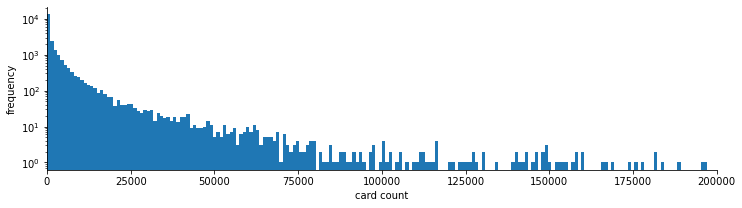

In [41]:
fig, ax = plt.subplots(1, figsize = (12,3))
plt.hist(counts['count'], bins = 1000);
ax.set_yscale('log')
ax.set_xlim([0, 200000])
ax.set_xlabel('card count'), ax.set_ylabel('frequency')
sns.despine()

We could consider removing low count cards. They don't contribute to clustering or dimensionality reduction much, as they aren't in many decks. But they _do_ significantly slow down these processes, as they dramatically increase the dimensionality of the data.

We could also consider removing basic lands, as one could argue that they are ubiquitous and therefore not informative for detecting differences between decks, which is the whole point of this exercise. But a counterargument is that they are relevant, as they contribute to deck similarity and sometimes can even indicate theme (e.g. Snow-Covered basics).

Whether or not these matter is subjective, I think. We'll follow the easiest route and just keep them.

# Generating the map coordinates

The first thing to do is generate the (x, y) coordinates of the map. We do this via a _dimensionality reduction_ algorithm named [UMAP](https://umap-learn.readthedocs.io/en/latest/), feeding in the matrix we have just generated.

 If you're interested in the specifics of the algorithm, I encourage you to read the [documentation](https://umap-learn.readthedocs.io/en/latest/), as it is wonderfully written. In brief, UMAP will collapse our high-dimensional data (`n x m  = ~1M x 23k`) into 2 dimensions, keeping decks that are similar close together.

We include commanders, partners, and companions as part of this process, although they have no more importance for a deck than any other card in the maindeck. We use the custom `CommanderMap` class, which will enable us to make submaps later as well.

__Warning__: The UMAP step takes about an hour to complete.

In [42]:
# initialize the commander map
commander_map = map_classes.CommanderMap(decklist_matrix, commander_decks, cdeck_subset)

# package in reference lookups
commander_map.date_matrix = date_matrix
commander_map.ci_matrix = ci_matrix

commander_map.card_idx_lookup = card_idx_lookup # key = card, value = column index in decklist_matrix
commander_map.deck_date_idx_lookup = deck_date_idx_lookup # key = deck_id, value = column index in date_matrix
commander_map.card_date_idx_lookup = card_date_idx_lookup # key = card, value = row index in date_matrix
commander_map.deck_ci_idx_lookup = deck_ci_idx_lookup # key = deck_id, value = column index in color identity matrix
commander_map.card_ci_idx_lookup = card_ci_idx_lookup # key = card, value = row index in ci_matrix

Alternatively, if you already have the Commander Map data, you can simply load it (this is useful for debugging).

In [45]:
commander_map.commander_decks = pd.read_csv(f'map_releases/{date}/map_intermediates/commander-decks.csv', low_memory=False).fillna('')

clusters_coordinates = pd.read_csv(f'map_releases/{date}/edh-map.csv', usecols = ['clusterID', 'x', 'y'])
commander_map.commander_decks[['x', 'y', 'clusterID']] = clusters_coordinates[['x', 'y', 'clusterID']].values
commander_map.cluster_labels = commander_map.commander_decks['clusterID'].values

In [ ]:
# reduce dimensionality with UMAP - intended for coordinates
commander_map.reduce_dimensionality(method = 'UMAP', n_dims = 2, coordinates = True,
                                    n_neighbors = 25)

Now let's plot it, highlighting by color identity

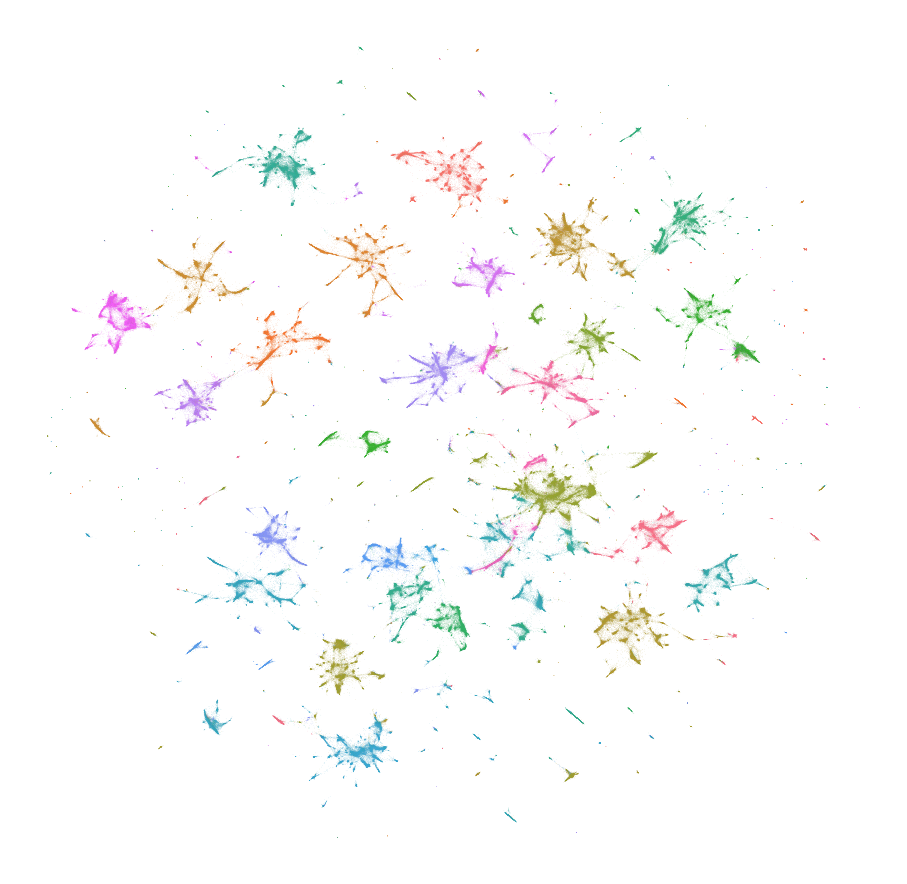

In [63]:
# plot umap embedding
fig, ax = plt.subplots(1, figsize = (16, 16))

sns.scatterplot(x = 'x', y = 'y', s = 0.1, ec = None, 
                data = commander_map.commander_decks, hue = 'colorIdentityID')

sns.despine(left = True, bottom = True)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.get_legend().remove()

This is the version of the map that is shown on the site.

# Clustering with HDBSCAN

UMAP doesn't define clusters - it may organize groups of decks that are similar on the plot, but it doesn't identify the groups themselves. We need clustering to do this. These data are difficult to cluster, but [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) works well.

The full scale of the data (`n x m` matrix) is far too large for HDBSCAN to process. So we pass it a UMAP embedding into 6 dimensions (effectively "compressing" our data to `n x 6`). Clustering on UMAP results is suspect, as it does not preserve distance, but it seems to work well for these data. We use [parameters recommended by the author](https://umap-learn.readthedocs.io/en/latest/clustering.html) for clustering on UMAP results:

In [43]:
# we begin by embedding to 6d for clustering
embedding_cluster = commander_map.reduce_dimensionality(method='UMAP', n_dims=6, coordinates=False, n_neighbors=25, min_dist=0)

/Users/jettcrowdis/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0, n_components=6, n_neighbors=25, random_state=RandomState(MT19937) at 0x7FCC85B60640, verbose=True)
Sun May  8 18:09:01 2022 Construct fuzzy simplicial set
Sun May  8 18:09:02 2022 Finding Nearest Neighbors
Sun May  8 18:09:02 2022 Building RP forest with 58 trees
Sun May  8 18:25:14 2022 metric NN descent for 20 iterations
	 1  /  20
	 2  /  20
	 3  /  20
	 4  /  20
	 5  /  20
	Stopping threshold met -- exiting after 5 iterations
Sun May  8 18:30:28 2022 Finished Nearest Neighbor Search
Sun May  8 18:30:43 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sun May  8 19:38:16 2022 Finished embedding


In [44]:
cluster_labels = commander_map.cluster_decks(method='HDBSCAN', min_cluster_size = 15)

In [63]:
print(len(set(commander_map.cluster_labels)))

2518


So HDBSCAN identifies a few thousand clusters in our data.

## Forcing clusters on unclustered decks

 We note, however, that HDBSCAN has refused to cluster a number of decks--nearly 1/4th of the dataset!

In [65]:
# HDBSCAN assigns a "cluster" of -1 to unclustered decks
sum(commander_map.cluster_labels == -1)

0

We'd like to assign these decks to a cluster. There is a built-in way to do this with HDBSCAN called [all_points_membership_vectors](https://hdbscan.readthedocs.io/en/latest/api.html#hdbscan.prediction.all_points_membership_vectors). It works by calculating, for all points, the probability it belongs to each of the defined clusters. We could then just take the cluster with the maximum probability.

Unfortunately, the function chokes on trying to assign nearly a million points to a few thousand clusters (i.e. takes longer than a full day to run, the limit of my patience). We implement a hack instead. For each unclustered point, we check the cluster assignment of the 50 nearest points, then assign the most common cluster among those neighbors to the point.

Mathematically, this isn't a great idea. HDBSCAN is based on density, which while similar to euclidean distance, is not the same. But empirically, it seems to work fairly well.

In [ ]:
commander_map.assign_unclustered()

These are the final clusters we use.

We can now visualize these clusters:

In [225]:
commander_map.cluster_labels = commander_map.commander_decks['clusterID']

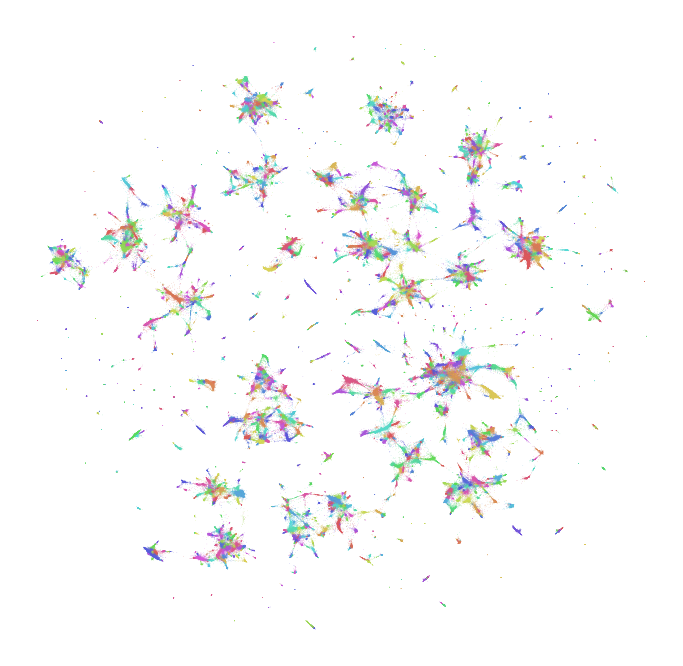

In [151]:
# define a color palette - randomly generated
np.random.seed(0)
hls = sns.color_palette("hls", np.max(commander_map.cluster_labels) + 1)
random.shuffle(hls)
palette = dict(zip(range(len(hls)), hls))

fig, ax = plt.subplots(1, figsize = (12, 12))
sns.scatterplot(x = 'x', y = 'y', data = commander_map.commander_decks, s = 0.2, ec = None, hue = 'clusterID', palette = palette)
ax.legend().remove() 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
sns.despine(bottom = True, left = True)

Not bad! The clusters vaguely follow the landmasses, and some close inspection shows that they do indeed obey density intuitions on the 2D map. These are the clusters depicted on the main map.

# Calculating the defining features of each cluster

Neither UMAP nor HDBSCAN tells us what is _important_ about these landmasses or clusters, i.e. what cards determine their formation. With the clusters in hand, we can determine this for ourselves.

## Defining noncard features

There are several defining features of a cluster that aren't related to the 99 cards of their maindeck. These include common commaders, common tribes and/or themes, and the common color identity. We calculate those here. Doing so is fairly straightforward - we simply group the dataframe by cluster and tally the most common commanders, etc

In [46]:
# calculate the defining traits
cluster_traits = commander_map.get_cluster_traits()
cluster_traits.head(5)

,clusterID,category,value,percent
0,0,commander-partnerID,"Geralf, Visionary Stitcher",99
1,1,commander-partnerID,Ruhan of the Fomori,97
2,1,commander-partnerID,Kynaios and Tiro of Meletis,1
3,1,commander-partnerID,"Shu Yun, the Silent Tempest",1
4,2,commander-partnerID,"Licia, Sanguine Tribune",92


For demonstration, we can examine the common tribes of the cluster that plays [Krenko, Mob Boss](https://scryfall.com/card/jmp/339/krenko-mob-boss) as its commander most often. 

In [47]:
krenko_clusters = cluster_traits[cluster_traits['value'] == 'Krenko, Mob Boss'].sort_values(by = 'percent', ascending = False)
krenko_clusters.head(3)

,clusterID,category,value,percent
7967,988,commander-partnerID,"Krenko, Mob Boss",99
9863,1203,commander-partnerID,"Krenko, Mob Boss",75
7303,911,commander-partnerID,"Krenko, Mob Boss",59


So there are a handful of clusters that have majority Krenko decks. Let's examine the top Krenko cluster

In [48]:
krenko_cluster = krenko_clusters['clusterID'].iloc[0]
cluster_traits[cluster_traits['clusterID'] == krenko_cluster]

,clusterID,category,value,percent
7967,988,commander-partnerID,"Krenko, Mob Boss",99
7968,988,commander-partnerID,"Grenzo, Havoc Raiser",1
25802,988,colorIdentityID,R,99
34011,988,themeID,,94
34012,988,themeID,goblin-tokens,6
44080,988,tribeID,Goblin,100


Unsurprisingly, this cluster has a very high percentage of Goblin decks. This data is what forms the cluster traits on the main map - the most played commanders in a cluster, etc

## Defining/synergistic maindeck cards

Next we determine which maindeck cards are defining for each cluster. What does this mean? Well, defining cards for a cluster are enriched in that cluster relative to all others. They are _synergistic_ for their cluster.

__How EDHREC does it__

[Muldrotha, the Gravetide](https://scryfall.com/card/dom/199/muldrotha-the-gravetide) decks, for example, commonly play both [Sol Ring](https://scryfall.com/card/cc2/7/sol-ring) and [Spore Frog](https://scryfall.com/card/mh1/180/spore-frog). But while [Sol Ring](https://scryfall.com/card/cc2/7/sol-ring) is played in most other decks, [Spore Frog](https://scryfall.com/card/mh1/180/spore-frog) is not, so [Spore Frog](https://scryfall.com/card/mh1/180/spore-frog) would thus emerge as a defining card of a Muldrotha cluster. EDHREC handles this through their "synergy" score, which is the play rate in the commander's deck minus the play rate in all other decks of that color identity. Sol Ring has a synergy score of 1% (80% play rate in Muldrotha decks - 79% play rate in other BUG decks), but Spore Frog has a synergy score of 51% (60% play in Muldrotha, 9% play in BUG). Their restriction based on color identity is reasonable, as without it, cards with more colors will have artificially inflated synergy scores.

__Why this doesn't work for us__

This is the intuition we're going for, but it doesn't fully work in our case. This is because our clusters don't strictly obey color identity. Consider the following example, which has indeed occurred in some releases of the data: a cluster of decks centered around a tribe (e.g. [Golems](https://edhrec.com/tribes/golems)). Most are of a particular color identity (RG), but one is a UW deck centered around Golems. [Swords to Plowshares](https://scryfall.com/card/voc/99/swords-to-plowshares) is played in exactly that deck, so its play rate in decks that could play it of that cluster is 100%. This means that its synergy will be artificially inflated because of color identity restrictions. So indeed, because defining cards _in this context_ means "cards that determine clustering" and we clustered using all decks regardless of color identity, we have to ignore the color identity of cards too. It's a bit wonky and is not the case for later submaps, but we do it here.

In this step, we also remove commanders and partners. While they can indeed define clusters, the common commanders will depict this well already.

__How to handle new cards__

New cards present an interesting problem. Their play rates in the dataset are lower than old cards, because some decks have not been updated. This also means that they influence clustering less than old cards.

This is something I'm fine with, but it presents an odd quandry for synergy. Decks that haven't been updated since a new card's release _can't_ play that card, by definition. So, in some sense, they should not contribute to the card's synergy. Controlling for when a deck was last updated vs. when a card was released allows us to highlight new cards that are being included in decks. In theory, we could run into the same issue as with color identity (a small number of decks having a large influence on synergy scores), but this will happen less often and only be relevant for new cards. This why we calculated the date matrix previously.

__How we actually calculate this__

We restrict our synergy calculations to the top 1000 cards played in each cluster, reasoning that synergistic cards will have high play rates. For each card, we calculate four numbers:

* The number of decks in the cluster that play the card ($n_{cluster}$)
* The number of decks in the cluster that could play the card but do not ($m_{cluster}$)
* The number of decks outside the cluster that play the card ($n_{other}$)
* The number of decks outside the cluster that could play the card but do not ($m_{other}$)

The synergy score for a card is then simply 

$$\text{synergy} = \text{play rate in cluster} - \text{play rate outside of cluster} = \dfrac{n_{cluster}}{n_{cluster} + m_{cluster}} - \dfrac{n_{other}}{n_{other} + m_{other}}$$

We make extensive use of [vectorization](https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html) to enable faster code, though it is still quite slow.

The first thing we do is calculate the number of decks that play each card in each cluster and the number of decks that COULD play each card but do not.

In [49]:
# by passing color_rule = ignore, we instruct the code to ignore color identity. Date is controlled for automatically.
# include_commanders being True means that commanders need to be subtracted from the count matrix
cluster_card_df, cluster_noncard_df = commander_map.get_cluster_card_counts(color_rule='ignore', include_commanders=True, verbose=True)

Building the cluster counts...
	Constructing the number of decks that play each card in each cluster. On cluster...0, 125, 250, 375, 500, 625, 750, 875, 1000, 1125, 1250, 1375, 1500, 1625, 1750, 1875, 2000, 2125, 2250, 2375, 2500, done
	Constructing number of decks that COULD play each card, controlling for date and optionally color identity. On cluster...0, 125, 250, 375, 500, 625, 750, 875, 1000, 1125, 1250, 1375, 1500, 1625, 1750, 1875, 2000, 2125, 2250, 2375, 2500, done


For example, let's look up that Krenko cluster and [Skirk Prospector](https://scryfall.com/card/dom/144/skirk-prospector)

In [50]:
num_krenko_decks = commander_map.commander_decks.query(f'clusterID == {krenko_cluster}').shape[0]
num_skirk_prospector = cluster_card_df.loc[krenko_cluster, 'Skirk Prospector']

# and how many could play Skirk Prospector but do not?
num_non_skirk_prospector = cluster_noncard_df.loc[krenko_cluster, 'Skirk Prospector']
print(f'{int(num_skirk_prospector)} out of {num_krenko_decks} decks play Skirk Prospector. {int(num_non_skirk_prospector)} could play it but do not.')

277 out of 283 decks play Skirk Prospector. 6 could play it but do not.


The fact that 100% of decks in this cluster CAN play Skirk Prospector is unsurprising, as Skirk Prospector is an old card. But what about a new card, like [Devilish Valet](https://scryfall.com/card/snc/105/devilish-valet)? Or a green card, like [Giant Growth](https://scryfall.com/card/war/162/giant-growth)?

In [51]:
num_devilish_valet = cluster_card_df.loc[krenko_cluster, 'Devilish Valet']
num_non_devilish_valet = cluster_noncard_df.loc[krenko_cluster, 'Devilish Valet']
print(f'{int(num_devilish_valet)} out of {num_krenko_decks} decks play Devilish Valet. {int(num_non_devilish_valet)} could play it but do not.')

num_giant_growth = cluster_card_df.loc[krenko_cluster, 'Giant Growth']
num_non_giant_growth = cluster_noncard_df.loc[krenko_cluster, 'Giant Growth']
print(f'{int(num_giant_growth)} out of {num_krenko_decks} decks play Giant Growth. {int(num_non_giant_growth)} could play it but do not.')

0 out of 283 decks play Devilish Valet. 20 could play it but do not.
0 out of 283 decks play Giant Growth. 283 could play it but do not.


So in this cluster, only 20 decks could play Devilish Valet (i.e. only 20 decks have been updated since its release). 

The fact that every deck in this cluster could play Giant Growth, when we know they are Krenko decks, may seem odd. But remember, _we did not restrict by color identity_, because clusters can have a mix of color identities. So the only restriction is based on date, and [Giant Growth](https://scryfall.com/card/war/162/giant-growth) was printed in Alpha.

With these card counts in hand, we can calculate card synergies. We can calculate the synergy of Skirk Prospector in the Krenko cluster, just as an example

In [52]:
other_clusters = [clust for clust in cluster_card_df.index if clust != krenko_cluster]

# number of decks in other clusters that play Skirk Prospector
other_cluster_counts = cluster_card_df.loc[other_clusters, 'Skirk Prospector'].sum()

# number of decks in other clusters that could play Skirk Prospector but do not
other_cluster_noncounts = cluster_noncard_df.loc[other_clusters, 'Skirk Prospector'].sum()

# synergy = play rate in cluster - play rate outside of cluster
synergy = num_skirk_prospector/(num_skirk_prospector + num_non_skirk_prospector) - other_cluster_counts/(other_cluster_counts + other_cluster_noncounts)
synergy = round(synergy, 2)

print(f'Skirk Prospector has a synergy of {synergy} in this cluster')

Skirk Prospector has a synergy of 0.96 in this cluster


Unsurprisingly, the synergy is extremely high. We now repeat this for all cards!

In [53]:
defining_cards = commander_map.get_defining_cards(include_synergy=True, n_scope=1000, verbose=True)

Calculating card synergies for clusters. On cluster...0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, done


As an example, we can examine the clusters with [Winota, Joiner of Forces](https://scryfall.com/card/iko/216/winota-joiner-of-forces) as its most common commander:

In [54]:
winota_clusters = cluster_traits.query('value == "Winota, Joiner of Forces"').sort_values(by = 'percent', ascending = False)
winota_clusters.head(4)

,clusterID,category,value,percent
4207,529,commander-partnerID,"Winota, Joiner of Forces",97
4208,530,commander-partnerID,"Winota, Joiner of Forces",97
1513,186,commander-partnerID,"Winota, Joiner of Forces",96
233,35,commander-partnerID,"Winota, Joiner of Forces",23


We can see that a number of clusters are majority [Winota, Joiner of Forces](https://scryfall.com/card/iko/216/winota-joiner-of-forces) decks.  We can examine the top 4 defining cards in some of these clusters:

In [55]:
winota_defining_cards = defining_cards[defining_cards['clusterID'].isin(winota_clusters.head(3)['clusterID'])]
winota_defining_cards.groupby('clusterID').head(4)

,clusterID,card,play_rate,synergy
0,186,Legion Warboss,0.98,0.97
2,186,Battlefield Forge,0.96,0.91
6,186,Raise the Alarm,0.90,0.89
1,186,Sacred Foundry,0.98,0.88
5,529,"Lena, Selfless Champion",0.83,0.83
4,529,Angrath's Marauders,0.83,0.82
6,529,Geist-Honored Monk,0.79,0.78
8,529,Blade Historian,0.76,0.76
4,530,Aven Mindcensor,0.93,0.89
7,530,Archon of Emeria,0.91,0.89


We can see that these clusters represent different flavors of Winota decks--1v1 decks, big mana decks, or cEDH versions.

## Average decklists

While not particularly important for the main map, defining an average decklist for each cluster is incredibly useful on submaps. The logic here is that sometimes users may want to see a decklist that best represents a cluster--for example, an average "Xenagos Wolf Tribal" deck.

"Average decklist" can mean many things, and we could define it in many ways. What people _expect_ is to see that the average decklist plays many of the defining cards. So for each deck in a cluster, we can define a "synergy score" that represents the average synergy of cards in the decklist. The "most representative" deck is the one with the highest synergy score.

Note that the decklists are deduplicated (so there is at max one basic per deck), meaning that we need to predict the basic lands to get back up to 100 cards. We do this based on the color distribution of the deck.

In [56]:
average_decklists = commander_map.calculate_average_decklists(verbose = True)

Calculating average decklists. On cluster...0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 

For example, we can again examine the Krenko cluster

In [57]:
krenko_cluster_average_decklist = average_decklists[krenko_cluster]

print(commander_map.commander_decks.iloc[krenko_cluster_average_decklist], '\n')

url                    https://moxfield.com/decks/GriNoGC7xk6xhllX9swBWg
savedate                                                      2021-06-05
commanderID                                             Krenko, Mob Boss
tribeID                                                           Goblin
colorIdentityID                                                        R
partnerID                                                               
themeID                                                                 
companionID                                                             
commander-partnerID                                     Krenko, Mob Boss
price                                                                 38
deckID                                                            801398
x                                                               20.78387
y                                                               4.767098
clusterID                                          

We can see that this is indeed a Krenko decklist. What about the maindeck?

In [58]:
average_krenko_deck = commander_map.cdecks[krenko_cluster_average_decklist]
average_krenko_deck.format_decklist(magic_cards, include_commanders=True)

['1 Krenko, Mob Boss',
 '',
 '1 Foundry Street Denizen',
 '1 Goblin Chirurgeon',
 '1 Goblin Motivator',
 '1 Goblin Sledder',
 '1 Skirk Prospector',
 '1 Torch Courier',
 '1 Dark-Dweller Oracle',
 '1 Generator Servant',
 '1 Goblin Instigator',
 '1 Goblin Lookout',
 '1 Goblin Wardriver',
 '1 Mogg War Marshal',
 '1 Wily Goblin',
 '1 Goblin King',
 '1 Goblin Matron',
 '1 Goblin Warchief',
 '1 Reckless Bushwhacker',
 '1 Beetleback Chief',
 '1 Goblin Trashmaster',
 '1 Ogre Battledriver',
 '1 Siege-Gang Commander',
 '1 Thermopod',
 '',
 '1 Faithless Looting',
 '1 Goblin War Strike',
 '1 Cathartic Reunion',
 '1 Dragon Fodder',
 "1 Krenko's Command",
 '1 Mob Justice',
 '1 Tormenting Voice',
 '1 Wrangle',
 '1 Act of Treason',
 '1 Besmirch',
 '1 Harness by Force',
 '1 Hijack',
 '1 Hordeling Outburst',
 "1 Kari Zev's Expertise",
 '1 Mark of Mutiny',
 '1 Threaten',
 '1 Traitorous Blood',
 '1 Empty the Warrens',
 '1 Burn at the Stake',
 '1 Goblin Rally',
 '',
 '1 Brightstone Ritual',
 '1 Battle Hymn'

We can see that there are many cards associated with Krenko decks.

# Create submaps

Submaps are maps that are restricted to a subset of the total data. There are five types of submaps we can make: commander, theme, tribe, color identity, and partner. We're going to make all of these. First, let's see how many submaps we need to make.

First, let's calculate the number of submaps we need to make. Partners make this a bit annoying, as we need to make A) a submap for each unique commander-partner pair, B) a submap for each partner composed of all decks that use that partner, and C) a submap for decks that use ONLY that partner (with no other commander).

In [36]:
# how many decks use a partner as a commander alone?
partner_alone = commander_decks[(commander_decks['commanderID'].isin(partners)) &
                                (commander_decks['partnerID'] == '')].groupby('commanderID').size().sort_values(ascending = False)
partner_alone.head(2)

commanderID
Cecily, Haunted Mage     103
Shabraz, the Skyshark     91
dtype: int64

In [38]:
grouped_data = []
fields = ['commander-partnerID', 'tribeID', 'themeID', 'colorIdentityID']
for col in fields:
    subdata = commander_decks.groupby(col).size().to_frame('count').reset_index().sort_values(by = 'count', ascending = False)
    subdata['category'] = col
    subdata = subdata.rename(columns = {col: 'value'})
    grouped_data.append(subdata)

grouped_data = pd.concat(grouped_data).reset_index(drop = True).sort_values(by = 'count', ascending = False)
grouped_data = grouped_data[['category', 'value', 'count']].reset_index(drop = True)

# we need to drop empty tribes and themes
empty_tribes_theme = grouped_data[(grouped_data['category'].isin(['tribeID', 'themeID'])) & 
                                  (grouped_data['value'] == '')].index
grouped_data = grouped_data.drop(index = empty_tribes_theme).reset_index(drop = True)
grouped_data.shape

(3104, 3)

In [39]:
grouped_data.head(2)

,category,value,count
0,colorIdentityID,WUBRG,84965
1,colorIdentityID,BG,63656


Next we add all decks that contain each partner.

In [40]:
partner_groups = []
for p in partners:
    all_p_decks = (commander_decks['commanderID'] == p) | (commander_decks['partnerID'] == p)

    if sum(all_p_decks):
        partner_groups.append(['partnerID', p, sum(all_p_decks)])
        
all_p_decks = pd.DataFrame(partner_groups,  columns = ['category', 'value', 'count'])

In [49]:
all_grouped_data = pd.concat([grouped_data, all_p_decks]).reset_index(drop = True)

# drop the backgrounds
all_grouped_data = all_grouped_data[~all_grouped_data['value'].isin(backgrounds)]

# drop instances where the partner is alone
all_grouped_data = all_grouped_data[~((all_grouped_data['category'] == 'commander-partnerID') &
                                      (all_grouped_data['value'].isin(partners)))]

# # sort and drop index
all_grouped_data = all_grouped_data.sort_values(by = 'count', ascending = False).reset_index(drop = True)

all_grouped_data.shape

(3119, 3)

For each submap, we will:

1. Create a 2D UMAP embedding using dynamic parameters based on number of decks
2. Cluster the data using a UMAP embedding with dynamic parameters and HDBSCAN.
3. Export the characteristics of the entire submap
    * This means calculating synergy scores, common commanders, themes, tribes, and color identities for decks in this submap relative to ALL other decks.
4. Calculate _cluster_ traits of each cluster in the submap.
    * This means calculating synergy scores, common commanders, themes, tribes, and color identities for each cluster relative to ALL other clusters.
    
As mentioned at the start of this notebook, synergistic cards in (3) represent cards synergistic for that submap relative to ALL other decks (e.g. synergistic cards in Atraxa decks relative to all other commander decks). Synergistic cards in (4) represents cards synergistic for different kinds of Atraxa decks relative to all other Atraxa decks.

One of the trickiest parts of this process is the UMAP and HDBSCAN parameters. For smaller datasets, different parameters are needed (there are, for example, fewer neighbors within a set distance with a smaller dataset). Dynamically setting these based on size _kind of_ works, but there are still several submaps that don't really work. Underclustering is the big enemy here, so if we detect underclustering, we drop our parameters and recluster.

__Controlling for color identity__

In calculating cluster defining cards and their synergies, we again account for the release date of the card as in the main map. On any submap where color identity can vary (e.g. Tribe and Theme), we do not account for color identity, nor do we account for color identity on coloridentity submaps (in fact, reporting synergy on these maps doesn't make any sense at all). 

For commander-partner submaps, however, we do account for color identity. EDHREC controls for color identity by comparing to other decks of the same color identity (so Spore Frog's play rate in Muldrotha is compared to other BUG decks). This doesn't seem optimal to me--shouldn't we compare to its play rate in any deck that could play green? This is instead what we do--so compare Spore Frog's play rate in Muldrotha compared to any deck that could play green).

# Calculate submap characteristics

Before we move forward with UMAP embedding, we can actually calculate the whole submap characteristics. This means determining which things like "which cards are defining for Atraxa decks?" We do this by declaring each category as a cluster.

Defining traits for entire submaps are a bit wonky here, e.g. common commanders and coloridentities doesn't make sense for a submap defined by a single commander. They are as follows:

1. Coloridentity: top cards, top commanders, top tribes/themes
2. Tribes/themes: synergy cards, top commanders, top themes/tribes (other)
3. Commanders: synergy cards, top themes/tribes

This will get a bit annoying, as we have to do this in different ways

In [ ]:
fields = ['tribeID', 'themeID', 'commander-partnerID', 'colorIdentityID']

# for each category, calculating the defining traits and cards
for cat in fields:
    print(cat)
    
    # copy the commander_map object with original references
    commander_submap = commander_map.copy_with_ref(commander_map.decklist_matrix, commander_map.commander_decks, 
                                                   commander_map.cdecks)
    
    # first, we map categories to clusters
    cat_values = commander_submap.commander_decks[cat].value_counts()
    cat_to_cluster = dict(zip(cat_values.index, range(len(cat_values))))
    cluster_to_cat = {v : k for (k, v) in cat_to_cluster.items()}
    
    # we overwrite the commander_map object with new "cluster" assignments
    commander_submap.commander_decks['clusterID'] = commander_submap.commander_decks[cat].apply(lambda value: cat_to_cluster[value])

    # now that we've declared clusters, we simply get the cluster defining cards and cluster traits
    drop_categories = [cat] if cat != 'commander-partnerID' else [cat, 'coloridentityID']
    commander_submap.get_cluster_traits(drop_categories = drop_categories)
    
    color_rule = 'ignore' if cat in ['tribeID', 'themeID', 'coloridentityID'] else 'superset'
    include_synergy = False if cat == 'coloridentity' else True
    
    # get the defining cards - will take a while because the empty tribe/themes are very large
    commander_submap.get_cluster_card_counts(color_rule=color_rule, include_commanders=True, verbose=True)
    commander_submap.get_defining_cards(include_synergy=include_synergy, n_scope=1000, verbose=True)
    
    # calculate average decklists
    commander_submap.calculate_average_decklists(verbose = True)
    
    print('\nExporting submap cards, traits, and average decklists...', end = '')
    for clust in sorted(list(set(commander_submap.cluster_defining_cards['clusterID']))):
        
        value = cluster_to_cat[clust]
        
        if value == '' and cat in ['tribeID', 'themeID']:
            continue

        # handle colorless
        out_value = value.lower() if value != '' else 'c'
        
        # make cards easily accessible
        if cat == 'commander-partnerID':
            out_value = re.sub("[^0-9a-zA-Z\-\_]+", "-", out_value).lower()
            
        out_dir = f'map_releases/{date}/submaps/{cat}/{out_value}'
        
        if not os.path.isdir(out_dir):
            os.mkdir(out_dir)
            
        # fetch json version of the cluster data
        cluster_json = commander_submap.jsonify_map([clust], magic_cards)
        
        with open(out_dir + '/submap.json', 'w') as outfile:
            json.dump(cluster_json, outfile)
            
        clear_output()

Next we do the partner submaps. These are a tad more annoying, as we cannot simply split the main map into clusters that represent partners. This is because a single deck can be included in two different partner submaps (e.g. a Thrasios + Tymna deck counts as both a Thrasios deck and a Tymna deck).

We also take the step of precomputing some values. Each partner submap compares decks with that partner to all other decks. Decks that do not have a partner will always be in the "outgroup" for each of these comparisons. Computing whether a deck COULD play each card is an expensive operation (requiring us to lookup the date/color identity of the decks and the date/color identity of the cards). We can precompute this value for all decks without a partner to save a ton of time.

In [67]:
commander_no_partner = commander_map.copy_with_ref(commander_map.decklist_matrix, commander_map.commander_decks, 
                                                   commander_map.cdecks)

# we do this by declaring decks without a partner as cluster = 0 and decks with a partner as cluster = 1
partner_indices = commander_no_partner.commander_decks[lambda row: (row['commanderID'].isin(partners)) | 
                                                                   (row['partnerID'].isin(partners))].index
commander_no_partner.commander_decks['clusterID'] = 0
commander_no_partner.commander_decks.loc[partner_indices, 'clusterID'] = 1

In [ ]:
_, cluster_noncard_df = commander_no_partner.get_cluster_card_counts(color_rule='ignore', 
                                                                     include_commanders=True, verbose=True, chunksize=1000)

In [101]:
# remember that cluster = 0 now depicts the number of decks without a partner that COULD play each card but do not
print(cluster_noncard_df.loc[0, '+2 Mace'], 'decks without a partner could play +2 Mace based on date but do not')
cluster_noncard_df

720778.0 decks could play +2 Mace based on date but do not


,+2 Mace,A Little Chat,Abandon Hope,Abandon Reason,Abandon the Post,Abandoned Outpost,Abandoned Sarcophagus,Abattoir Ghoul,Abbey Gargoyles,Abbey Griffin,...,Zulaport Enforcer,"Zuo Ci, the Mocking Sage",Zur the Enchanter,Zur's Weirding,Zuran Enchanter,Zuran Orb,Zuran Spellcaster,Zurgo Bellstriker,Zurgo Helmsmasher,"Zurzoth, Chaos Rider"
0,720778.0,105455.0,1029090.0,1028135.0,642417.0,1029147.0,1026217.0,1029130.0,1029307.0,1029257.0,...,1029247.0,1029324.0,1024561.0,1027535.0,1029331.0,1019750.0,1028822.0,1028493.0,1028078.0,990969.0
1,59429.0,8402.0,88537.0,88536.0,52338.0,88538.0,88280.0,88530.0,88541.0,88541.0,...,88545.0,88546.0,88297.0,88486.0,88546.0,88132.0,88400.0,88407.0,88483.0,85913.0


In [102]:
# our precalculated noncard counts for cluster = 0 (no partner)
precomputed_no_partner_noncard_counts = {0: cluster_noncard_df.loc[0, :]}

In [ ]:
partner_data = grouped_data[all_all_grouped_data['category'] == 'partnerID']

# for each category, calculating the defining traits and cards
for index, row in partner_data.iterrows():
    p = row['value']
    print(p)

    # copy the commander_map object with original references
    commander_submap = commander_map.copy_with_ref(commander_map.decklist_matrix, commander_map.commander_decks, 
                                                   commander_map.cdecks)
    
    # map the partner assignments to clusters. Designate decks with no partner as 0,
    # decks with some partner as 1, and decks with the partner in question as 2 (we want 2).
    any_p_indices = commander_submap.commander_decks[lambda row: (row['commanderID'].isin(partners)) | 
                                                                 (row['partnerID'].isin(partners))].index
    specific_p_indices = commander_submap.commander_decks[lambda row: (row['commanderID'] == p) | 
                                                                      (row['partnerID'] == p)].index
    commander_submap.commander_decks['clusterID'] = 0
    commander_submap.commander_decks.loc[any_p_indices, 'clusterID'] = 1
    commander_submap.commander_decks.loc[specific_p_indices, 'clusterID'] = 2

    # now that we've declared clusters, we simply get the cluster defining cards and cluster traits
    commander_submap.get_cluster_traits()
    
    color_rule = 'ignore'
    include_synergy = True
    
    # get the defining cards, passing precomputed data for cluster = 0
    commander_submap.get_cluster_card_counts(color_rule=color_rule, include_commanders=True, verbose=True,
                                             precomputed_noncard=precomputed_no_partner_noncard_counts)
    commander_submap.get_defining_cards(include_synergy=include_synergy, n_scope=1000, verbose=True)
    
    # calculate average decklists, ignoring cluster 0 and 1
    commander_submap.calculate_average_decklists(ignore_clusters=(0, 1), verbose = True)
    
    print('\nExporting submap cards, traits, and average decklists...', end = '')
    for clust in sorted(list(set(commander_submap.cluster_defining_cards['clusterID']))):
        
        if clust in [0, 1]:
            continue

        # handle colorless
        out_value = p
        out_value = re.sub("[^0-9a-zA-Z\-\_]+", "-", out_value).lower()
            
        out_dir = f'map_releases/{date}/submaps/commander-partnerID/{out_value}'
        
        if not os.path.isdir(out_dir):
            os.mkdir(out_dir)
            
        # fetch json version of the cluster data
        cluster_json = commander_submap.jsonify_map([clust], magic_cards)
        
        with open(out_dir + '/submap.json', 'w') as outfile:
            json.dump(cluster_json, outfile)
            
    # clear printed outputs
    clear_output()

Next we actually build the submaps. 

# Building the submaps

We'll loop through all the submaps we have to create, extract their data from the `commander_map.commander_decks` dataframe and `commander_map.decklist_matrix`, and then apply the entire 2D UMAP > UMAP + clustering > calculate defining traits and cards process.

## Changing algorithm parameters

As mentioned earlier, we have to be a bit more judicious with the parameters. The first thing we do is scale some of the parameters based on the number of input decklists.

But this tends to not work super well. There are some maps that become substantially underclustered with these metrics. In general, we prefer overclustering, as underclustering doesn't help people determine different ways to build decks. Overclustering might obscure some of this, but more information is the lesser evil.

To do this, we check the results of clustering after clustering. If it appears that the data is underclustered, we recluster after reducing `minclustersize`. We assess the results of clustering by looking at the [entropy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) of the results. A low entropy indicates that many decks are contained within a single or small number of clusters (in this data, this is almost always 1 cluster). We also assess the percentage of decks in the largest cluster. If `entropy < 1` and `max_percentage > 0.80`, we recluster.

In [112]:
import warnings

In [291]:
np.random.seed(0)
random_state = np.random.RandomState(0)
warnings.filterwarnings('ignore')

for index in all_grouped_data.index:
    category, value, count = all_grouped_data.loc[index, ['category', 'value', 'count']]
    print(index, value)

    out_value = value.lower() if value != '' else 'c'

    # make cards easily accessible
    if category in ['commander-partnerID', 'partnerID']:
        out_value = re.sub("[^0-9a-zA-Z\-\_]+", "-", out_value)
    
    out_dir = f'map_releases/{date}/submaps/{category}/{out_value}'
    
    # partners are accessed through commander-partnerID
    if category == 'partnerID':
        out_dir = out_dir.replace('partnerID', 'commander-partnerID')

    if not os.path.isdir(out_dir):
        os.makedir(out_dir)

    # extract the appropriate data by subsetting the main map data to the category in question
    if category != 'partnerID':
        submap_decks = commander_map.commander_decks[commander_map.commander_decks[category] == value].reset_index(drop=True).copy()
    else:
        submap_decks = commander_map.commander_decks[(commander_map.commander_decks['commanderID'] == value) |
                                                     (commander_map.commander_decks['partnerID'] == value)].reset_index(drop=True).copy()
    submap_decklist_matrix = commander_map.decklist_matrix[submap_decks['deckID'].values, :]
    submap_cdecks = {deck_id: commander_map.cdecks[deck_id] for deck_id in submap_decks['deckID'].values}
    
    # remove cards that are absent in these decks and establish new lookups
    card_counts = submap_decklist_matrix.sum(axis = 0).A1
    played_cards = np.array(list(card_idx_lookup.keys()))[card_counts > 0]
    submap_decklist_matrix = submap_decklist_matrix[:, card_counts > 0]
    submap_card_idx_lookup = {cardname: i for i, cardname in enumerate(played_cards)}
    
    # establish the submap object
    commander_submap = map_classes.CommanderMap(submap_decklist_matrix, submap_decks, submap_cdecks)

    # most lookup references are the same
    commander_submap.date_matrix = date_matrix
    commander_submap.ci_matrix = ci_matrix
    commander_submap.card_idx_lookup = submap_card_idx_lookup # key = card, value = column index in decklist_matrix
    commander_submap.deck_date_idx_lookup = deck_date_idx_lookup # key = deck_id, value = column index in date_matrix
    commander_submap.card_date_idx_lookup = card_date_idx_lookup # key = card, value = row index in date_matrix
    commander_submap.deck_ci_idx_lookup = deck_ci_idx_lookup # key = deck_id, value = column index in color identity matrix
    commander_submap.card_ci_idx_lookup = card_ci_idx_lookup # key = card, value = row index in ci_matrix
    
    print('Running UMAP and clustering...')
    # run 2D embedding
    commander_submap.reduce_dimensionality(method='UMAP', n_dims=2, coordinates=True)
    
    # run embedding for clustering, then run clustering
    nneighbors, minclustersize = calculate.get_parameters(len(commander_submap.commander_decks))
    entropy, max_cluster_perc = 0, 1
    
    num_iter = 0
    print('\n')
    while entropy < 1 and max_cluster_perc > 0.8:
        print(f'On iteration {num_iter}...')

        commander_submap.reduce_dimensionality(method='UMAP', n_dims=4, coordinates=False, 
                                           n_neighbors=nneighbors, min_dist=0)
        commander_submap.cluster_decks(method='HDBSCAN', min_cluster_size = minclustersize)
        commander_submap.assign_unclustered(n_neighbors=15)

        # next we assess the entropy and max cluster size
        cluster_sizes = commander_submap.commander_decks.groupby(['clusterID']).size()
        cluster_sizes = cluster_sizes/cluster_sizes.sum()
        entropy = scipy.stats.entropy(cluster_sizes)
        max_cluster_perc = np.max(cluster_sizes)
        num_iter += 1

        # if there are less than 200 decks, we always exit
        if len(commander_submap.commander_decks) <= 200:
            entropy, max_cluster_perc = np.inf, 0

        # otherwise, we recluster after dropping the minimum cluster size
        else:
            minclustersize -= 1
    
    # get the defining traits
    drop_categories = [category] if category != 'commander-partnerID' else [category, 'coloridentityID']
    cluster_traits = commander_submap.get_cluster_traits(drop_categories=drop_categories)
    cluster_card_df, cluster_noncard_df = commander_submap.get_cluster_card_counts(color_rule='ignore', 
                                                                                   include_commanders=True, 
                                                                                   verbose=True)
    
    # if there is only one cluster, synergy doesn't make any sense
    include_synergy = False if len(set(commander_submap.cluster_labels)) == 1 else True
    defining_cards = commander_submap.get_defining_cards(include_synergy=include_synergy, n_scope=200, verbose=True)
    average_decklists = commander_submap.calculate_average_decklists(verbose=True)
    
    # export all clusters
    cluster_json = commander_submap.jsonify_map(np.unique(commander_submap.cluster_labels), magic_cards)

    with open(out_dir + '/edh-submap-clusters.json', 'w') as outfile:
        json.dump(cluster_json, outfile)
    
    # export the submap coordinates
    export_cols = ['deckID', 'x', 'y', 'commander-partnerID', 'colorIdentityID', 'tribeID', 'themeID', 'price', 'clusterID']
    export_df = commander_submap.commander_decks[export_cols].copy().rename(columns = {'commander-partnerID': 'commanderID'})
    export_df.to_csv(out_dir + '/edh-submap.csv', index=False)
    
    clear_output()

And there we have it! Every single submap now has three files:

1. `submap.json`, which gives the defining traits and cards of that submap relative to ALL other decks
2. `edh-submap-clusters.json`, which gives the defining traits and cards of each cluster within the submap relative to all other clusters
3. `edh-submap.csv`, which gives the (x,y) position of each deck in the submap as well as its other characteristics

# The End

There you have it! The code to generate the Commander Map. If you're interested in collaborating on any content or analyses related to the Commander Map, feel free to reach out to mail@luckypaper.co